# Fine-tuning a model with the Trainer API

Transformer는 **Trainer class**를 제공하여 사전학습모델의 fine-tuning을 도와준다!



In [6]:
import transformers
import datasets
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## Training

Tranier 정의 전에, 

첫 번째 단계는 Trinaer는 Trainer는 training과 evaluation에 사용할 모든 하이퍼파라미터를 포함한 **TrainingArguments class**를 정의한다.

제공해아하는 유일한 argument는 도중에 checkpoints할 곳과 훈련된 model이 저장되어야할 directory이다!

In [8]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")

In [10]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

사전교육된모델을 instantiating하면 경고가 난다.

=> 이유는 BERT는 문장 쌍 분류를 사전학습하지 않았기 때문이다.

=> 그래서, 사전학습된 모델의 head는 버려지고 sequence classification에 적합한 새로운 head를 추가했다!

Warning 부분은 일부 가중치(떨어진 사전학습된 head의 가중치)가 사용 X -> 다른 가중치가 임의로 초기화(새로운 head의 가중치)가 되었음을 표시!

=> 그러므로, 모델을 train하는 것을 권장한다!

모델은 Trainer를 정의할 수 있다.

* model
* training_args
* traing and validation datasets
* data_collator
* tokenizer

In [11]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

toknizer가 통과되면, default로 data_collator는 이전에 정의한 DataCollatorWithPadding이 될 것이다.

그래서 data_collator=data_collator를 skip할 수 있을 것이다.

In [12]:
trainer.train() # 모델 fine-tuning

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx.
***** Running training *****
  Num examples = 3668
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1377


Step,Training Loss
500,0.482500
1000,0.270200


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1377, training_loss=0.30845741266432064, metrics={'train_runtime': 378.3928, 'train_samples_per_second': 29.081, 'train_steps_per_second': 3.639, 'total_flos': 405470580750720.0, 'train_loss': 0.30845741266432064, 'epoch': 3.0})

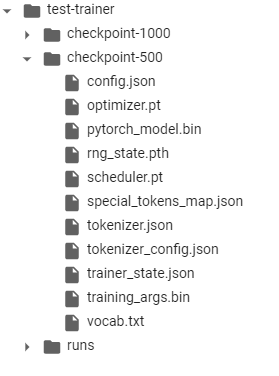

train() 시에, fine-tuning이 시작되고 500 step마다 traiing loss를 말해준다!

**제대로 수행되고 있는지는 알 수 없다.**

* 이유1: evaluation strategy를 step이나 epoch으로 설정하면서 training동안 평가할 수 있도록 Tranier에게 말하지 않았다.
* 이유2: Trainer는 evaluation동안 metric을 계산하는 compute_metrics 함수를 제공하지 않는다. -> 단지 손실만 출력

## Evaluation

**compute_metrics** function을 구축할 것이다!

함수는 predictions field와 labe_ids field와 함께 지명된 튜플인 **EvalPrediction** 개체를 가져와야 한다!

그리고 string -> float로 mapping한 dictionary를 return한다!

모델로부터 몇 가지 예측을 얻기 위해서 **Trainer.predict**를 사용할 것이다!

In [13]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx.
***** Running Prediction *****
  Num examples = 408
  Batch size = 8


(408, 2) (408,)


predict output -> predictions, label_ids, metrics

metrics: loss와 일부 시간의 metric(평균 예측 시 소요 시간)만 포함

**compute_metrics function을 완수하면 Trainer에게 전달되고 compute_metrics도 metrics에 반환될 것이다!**

In [18]:
predictions.metrics

{'test_loss': 0.6257660388946533,
 'test_runtime': 4.0511,
 'test_samples_per_second': 100.714,
 'test_steps_per_second': 12.589}

In [14]:
import numpy as np
preds = np.argmax(predictions.predictions, axis=-1)

In [15]:
preds #label 예측 array 만들기!

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,

**compute_metric 함수를 만들기 위해서 Datasets library의 metrics을 사용!**

**load_metric을 사용하여 dataset을 load한 것처럼 쉽게 MRPC Dataset와 관련된 metric을 load할 수 있다.**

In [16]:
from datasets import load_metric

metric = load_metric("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

{'accuracy': 0.8676470588235294, 'f1': 0.906896551724138}

GLUE benckmark의 MRPC Dataset에 대한 결과를 평가하는데 사용되는 2가지 metric이다!

-> 정확도, F1-score



In [19]:
def compute_metrics(eval_preds):
    metric = load_metric("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

compute_metrics 함수를 포함한 Trainer를 정의할 수 있다.

In [ ]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

**evaluation_strategy를 epoch으로 설정하고 새로운 TrainingArguments를 만들었다!**

그렇지 않으면, 이미 trained한 모델의 training을 계속해야한다!

In [20]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx.
***** Running training *****
  Num examples = 3668
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1377


Step,Training Loss
500,0.077000
1000,0.079800


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1377, training_loss=0.07859577298077795, metrics={'train_runtime': 375.2854, 'train_samples_per_second': 29.322, 'train_steps_per_second': 3.669, 'total_flos': 406502469420960.0, 'train_loss': 0.07859577298077795, 'epoch': 3.0})

앞처럼 설정할 시, loss 외에도 validation loss와 metrics도 출력이 된다!



In [21]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)
metric = load_metric("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx.
***** Running Prediction *****
  Num examples = 408
  Batch size = 8


(408, 2) (408,)


{'accuracy': 0.8676470588235294, 'f1': 0.906896551724138}